# Example: Drift of Maximum Sharpe Ratio Portfolios
In this example, we will use historical data to compute the maximum Sharpe ratio portfolio, and then compute the drift of this portfolio over time. 

> __Learning Objectives:__
> 
> By the end of this example, you will be able to:
> * __Compute maximum Sharpe ratio portfolios__ using single index model parameters to identify the optimal risk-adjusted portfolio that maximizes the excess return per unit of risk.
> * __Track portfolio drift__ over time as relative weights of assets change due to price movements, even when the number of shares held in each asset remains constant.
> * __Analyze drift implications__ by computing how the portfolio's alpha and beta values evolve as the asset allocation drifts away from its initial optimal composition.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include-drift.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` until `09-26-2025`, along with data for several exchange-traded funds and volatility products during that time period.

Let's load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [6]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 482 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  "BBWI" => 182×8 DataFrame…
  "CAG"  => 182×8 DataFrame…
  "GPC"  => 182×8 DataFrame…
  "FCX"  => 182×8 DataFrame…
  "GILD" => 182×8 DataFrame…
  "INFO" => 182×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [8]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow; # maximum number of trading days in our dataset

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [10]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [12]:
list_of_tickers_price_data = keys(dataset) |> collect |> sort;

Finally, let's load the single index model parameters that we computed in the previous example. We'll store this data in the `sim_model_parameters::Dict{String,NamedTuple}` variable:

In [14]:
sim_model_parameters, Ḡₘ, Varₘ = let

    # initialize -
    path_to_sim_model_parameters = joinpath(_PATH_TO_DATA,"SIMs-SPY-SP500-01-03-14-to-12-31-24.jld2");
    sim_model_parameters = JLD2.load(path_to_sim_model_parameters);
    parameters = sim_model_parameters["data"]; # return

    Ḡₘ = sim_model_parameters["Ḡₘ"]; # mean of market growth rates
    Varₘ = sim_model_parameters["Varₘ"]; # variance of market growth

    # return -
    parameters, Ḡₘ, Varₘ;
end;

Now let's get a list of all tickers for which we have single index model parameters:

In [16]:
tickers_that_we_sim_sim_data_for = keys(sim_model_parameters) |> collect |> sort;

We need to use only the tickers for which we have both price data and SIM parameters. We'll compute the intersection of the two lists and store the result in the `list_of_tickers::Array{String,1}` variable:

In [18]:
list_of_tickers = intersect(tickers_that_we_sim_sim_data_for, list_of_tickers_price_data);

In [19]:
list_of_tickers

420-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 "ADP"
 "ADSK"
 "AEE"
 ⋮
 "WST"
 "WU"
 "WY"
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [21]:
Δt = (1.0/252.0); # time step for 1-trading day (units: 1/year)
investment_budget = 1000.0; # investment budget (units: $)
risk_free_rate = 0.0389; # hypothetical continuous compounded risk free rate (units: 1/year)

___

# Task 1: Compute the Maximum Sharpe Ratio Portfolio
In this task, we will compute the maximum Sharpe ratio portfolio using the single index model parameters we loaded earlier.

Let's start by specifying a collection of ticker symbols, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers::Array{String,1}` array.

In [24]:
my_list_of_tickers = ["AAPL", "MSFT", "INTC", "MU", "AMD", "GS", "BAC", "WFC", "C", "F", "GM", 
    "JNJ", "CHD", "PG", "UPS", "COST", "TGT", "WMT", "MRK", "PFE", "ADBE"]; # tickers selected for portfolio

### SIM-Based Risk and Return Matrices
Next, we'll compute the expected return vector and covariance matrix using the single index model. We'll use the SIM formula for expected returns and the SIM-derived covariance structure. Store these in the `Ĝ_sim::Array{Float64,1}` and `Σ̂_sim::Array{Float64,2}` variables:

In [26]:
Ĝ_sim, Σ̂_sim = let

    # initialize -
    N = length(my_list_of_tickers); # number of assets in portfolio
    Ĝ_sim = Array{Float64,1}(); # expected return vector
    Σ̂_sim = Array{Float64,2}(undef, N, N); # covariance matrix for *our* portfolio
    σ²ₘ = Varₘ; # variance of market factor (load from saved data, historical from 2014-2024)

    # compute the expected growth rate (return) for each of our tickers -
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        data = sim_model_parameters[ticker]; # get the data for this ticker
        αᵢ = data.alpha; # get alpha
        βᵢ = data.beta; # get beta
        Ḡᵢ = αᵢ + βᵢ* Ḡₘ; # compute the growth rate for this ticker
        push!(Ĝ_sim, Ḡᵢ); # append growth rate value to Ĝ_sim
    end

    # compute the covariance matrix using the single index model -
    for i ∈ eachindex(my_list_of_tickers)

        ticker_i = my_list_of_tickers[i];
        data_i = sim_model_parameters[ticker_i]; # get the data for ticker i
        βᵢ = data_i.beta; # get beta for ticker i
        σ²_εᵢ = (Δt)*data_i.training_variance; # residual variance for ticker i

        for j ∈ eachindex(my_list_of_tickers)
            
            ticker_j = my_list_of_tickers[j];
            data_j = sim_model_parameters[ticker_j]; # get the data for ticker j
            βⱼ = data_j.beta; # get beta for ticker j
            σ²_εⱼ = (Δt)*data_j.training_variance; # residual variance for ticker j
            
            if i == j
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ + σ²_εᵢ; # diagonal elements
            else
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ; # off-diagonal elements
            end
        end
    end

    (Ĝ_sim, Σ̂_sim*Δt); # return
end;

Now we'll compute the maximum Sharpe ratio portfolio by constructing an optimization problem. We need to build a `MySharpeRatioPortfolioChoiceProblem` object to hold the parameters and bounds for the portfolio optimization problem. We'll store this in the `model::MySharpeRatioPortfolioChoiceProblem` variable:

In [28]:
model = let

    # initialize - 
    N = length(my_list_of_tickers); # number of assets in portfolio
    α = zeros(N);
    β = zeros(N);

    # grab alphas and betas for our tickers -
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        data = sim_model_parameters[ticker]; # get the data for this ticker
        α[i] = data.alpha; # get alpha
        β[i] = data.beta; # get beta
    end

    # build the model
    model = build(MySharpeRatioPortfolioChoiceProblem, (
        Σ = Σ̂_sim,
        risk_free_rate = risk_free_rate,
        gₘ = Ḡₘ,
        α = α,
        β = β,
        τ = 1.0, # placeholder, will be set later
    ));

    model; # return -
end;

To solve the maximum Sharpe ratio problem, we reformulate it as a Second Order Cone Program (SOCP). We need to specify a lower bound for an auxiliary variable $\tau$ (where $\text{SR}(w)\ge \tau$). We compute the (initial value) of the lower bound $L$ by finding the maximum ratio of excess growth to standard deviation for __each individual asset__:
$$
L = \max_i \left\{\frac{\alpha_i + \beta_i \mathbb{E}[g_M] - r_f}{\sqrt{\Sigma_{ii}}} \right\}\quad\forall{i}\in\mathcal{P}
$$
where $\alpha_i$ is the asset's alpha, $\beta_i$ is the asset's beta, $\mathbb{E}[g_M]$ is the expected market return, $r_f$ is the risk-free rate, and $\Sigma_{ii}$ is the asset's variance.
This bound is stored in the `L::Float64` variable. The parameter $\tau$ must be at least as large as this lower bound for the SOCP to have an optimal solution with a well-defined Sharpe ratio.

In [30]:
L = let

    # initialize -
    α = model.α
    β = model.β
    rfr = model.risk_free_rate
    gₘ = model.gₘ
    Σ = model.Σ
    d = length(α)
    c = α .+ β .* gₘ .- rfr .* ones(d); # vector c

    tau_lower_bound_array = Array{Float64,1}();
    for i ∈ 1:d
        value = c[i]/sqrt(Σ[i,i]);
        push!(tau_lower_bound_array, value);
    end

    L = max(0, maximum(tau_lower_bound_array) ); # return
end

0.8504064345831902

Now we solve the maximum Sharpe ratio portfolio problem using the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MySharpeRatioPortfolioChoiceProblem}). The solution is stored in the `sharpe_solution::NamedTuple` variable, which contains the risk value, reward value, allocation weights, and the Sharpe ratio for the optimal portfolio. 

> __Solver note:__ The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MySharpeRatioPortfolioChoiceProblem}) uses the [JuMP.jl package](https://jump.dev/JuMP.jl/stable/) to formulate and solve the optimization problem. JuMP provides a high-level interface for defining optimization problems and supports various solvers. In this case, we use the [`COSMO.jl` solver from the University of Oxford](https://oxfordcontrol.github.io/COSMO.jl/stable/). 

In the code blow below, we compute the optimal Sharpe ratio portfolio by iteratively increasing the lower bound $L$ until until we no longer have an optimal solution, i.e., until our problem is no longer feasible.

In [32]:
sharpe_solution = let
   
    # initialize -
    solution = nothing;
    Lᵢ = L; # store initial lower bound value
    should_stop_loop = false; # we'll keep iterating until we are no longer optimal

    while should_stop_loop == false
         
        # solve the problem with τ = L (the computed lower bound)
        model.τ = Lᵢ; # set the lower bound on the desired Sharpe ratio for this iteration
        solution_dictionary = solve(model) # solve for this Lᵢ
        status_flag = solution_dictionary["status"]; # get the status flag
        
        if (status_flag == MathOptInterface.OPTIMAL) # if optimal solution found, grab the results
            risk_value = solution_dictionary["denominator"]; # risk value (denominator of Sharpe ratio)
            reward_value = solution_dictionary["numerator"]; # reward value (numerator of Sharpe ratio)
            allocation = solution_dictionary["argmax"]; # allocation weights
            sharpe_ratio = solution_dictionary["sharpe_ratio"]; # computed Sharpe ratio
        
            solution = (risk = risk_value, reward = reward_value, w = allocation, 
                sharpe_ratio = sharpe_ratio, status = status_flag);

            # update the Sharpe ratio lower bound -
            Lᵢ += 0.001; # increment lower bound and go around again
        else
            should_stop_loop = true; # Bam! We blew up. Exit the loop.
        end
    end

    solution; # return
end;

------------------------------------------------------------------
          COSMO v0.8.9 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{21},
          constraints: A ∈ R^{45x21} (315 nnz),
          matrix size to factor: 66x66,
          Floating-point precision: Float64
Sets:     Nonnegatives of dim: 22
          SecondOrderCone of dim: 22
          ZeroSet of dim: 1
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 50000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: COSMO.QdldlKKTSolver
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol: 2.0
Setu

In [33]:
sharpe_solution

(risk = 0.15801261621478316, reward = 0.1705603117840445, w = [0.2417395446484773, 0.27574086320888536, 7.697940719753564e-7, 3.889259840543256e-7, 0.05537064649095721, 3.1212679760634663e-7, 4.5252174467456953e-7, 5.632243933696234e-7, 7.187653919006808e-7, 1.0223495119814186e-6  …  1.3842551480045533e-7, 0.02153033901626262, 1.464316936210627e-7, 4.962049048937316e-7, 0.35836249869074327, 2.801186984553693e-8, 0.04724977807603699, 2.7797364813300615e-8, 4.802613465123291e-7, 4.64465301392398e-8], sharpe_ratio = 1.0794094539400925, status = OPTIMAL)

__What's in the optimal Sharpe ratio portfolio?__ Let's take a look at the makeup of that portfolio. First, we'll compute the number of shares that we need to purchase (given our investment budget) for each asset. We'll store this in the `nₒ::Array{Float64,1}` variable:

In [35]:
nₒ = let
    
    # initialize -
    N = length(my_list_of_tickers); # number of assets in portfolio
    n = zeros(Float64, N); # number of shares to purchase for each asset
    w = sharpe_solution.w .|> x -> round(x, digits=4) |> abs # optimal weights
    prices = Array{Float64,1}(undef, N); # prices vector

    # get prices for each asset
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        prices[i] = dataset[ticker][1, :open]; # get the opening price on Jan 3, 2025
    end

    # get the number of shares to purchase for each asset
    for i in 1:N
        n[i] = investment_budget * w[i] / prices[i];
    end

    n; # return
end;

Let's build a table to summarize the maximum Sharpe ratio portfolio allocation. The table shows the ticker, alpha, beta, allocation weight, current price, number of shares, and total cost for each asset in the portfolio:

In [37]:
let

    # initialize -
    df = DataFrame();

    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        α = sim_model_parameters[ticker].alpha;
        β = sim_model_parameters[ticker].beta;
        price = dataset[ticker][1, :open]; # get the opening price on Jan 3, 2025
        weight = sharpe_solution.w[i] |> x -> round(x, digits=4) |> abs;
        shares = nₒ[i] |> x -> round(x, digits=4);
       
        row_df = (
            ticker = ticker,
            α = round(α, digits=4),
            β = round(β, digits=4),
            w = weight,
            price = round(price, digits=4),
            n = shares,
            cost = round(shares * price, digits=2),
        )
        push!(df, row_df);
    end

    beta_vec = df[:,:β] |> collect;
    alpha_vec = df[:,:α] |> collect;
    w_vec = df[:,:w] |> collect;
    price_vec = df[:,:price] |> collect;

    # compute the total -
    total = df[:,:w] |> sum
    last_row = (
        ticker = "total",
        α = dot(alpha_vec,w_vec),
        β = dot(beta_vec,w_vec),
        w = total,
        price = 0.0,
        n = sum(nₒ),
        cost = round(sum(df[:,:cost]), digits=2),
    )
    push!(df,last_row)

    pretty_table(df, backend = :text, fit_table_in_display_vertically = false,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- ---------- ---------- --------- --------- --------- ---------
  ticker          α          β         w     price         n      cost 
  String    Float64    Float64   Float64   Float64   Float64   Float64 
 -------- ---------- ---------- --------- --------- --------- ---------
    AAPL     0.1061     1.1946    0.2417    243.36    0.9932    241.71
    MSFT     0.0999      1.152    0.2757    421.08    0.6547    275.68
    INTC    -0.1484     1.1843       0.0     20.39       0.0       0.0
      MU    -0.0532     1.6953       0.0     87.95       0.0       0.0
     AMD     0.1275     1.7392    0.0554    121.65    0.4554      55.4
      GS    -0.0326       1.31       0.0     581.0       0.0       0.0
     BAC    -0.0545     1.3594       0.0     44.75       0.0       0.0
     WFC    -0.0914     1.2383       0.0     70.35       0.0       0.0
       C    -0.1334     1.5008       0.0     70.88       0.0       0.0
       F    -0.1928     1.4336       0.0      9.69       0.0       0.0
  

## Task 2: Compute the Drift of the Maximum Sharpe Ratio Portfolio
In this task, we will compute the drift of the maximum Sharpe ratio portfolio over time. We'll track the wealth fraction of each of the assets in the portfolio, and the portfolio's $\alpha_{\mathcal{P}}$ and $\beta_{\mathcal{P}}$ values over time.


Let's compute the value of a portfolio $\mathcal{P}$ for a `number_of_days` forward in time, where the initial composition of the portfolio $\mathcal{P}$ lies on the efficient frontier. To start, let's specify how many days to compute in the `number_of_days::Int64` variable:

In [39]:
number_of_days = 182; # we hold the portfolio for this many trading days

Next, let's compute the performance of portfolio $\mathcal{P}$ by computing the value of each asset in the portfolio and the total value of the portfolio, starting from the initial allocation. We'll store this data in the `portfolio_performance_array::Array{Float64,2}` array.

Each `row` of the `portfolio_performance_array` corresponds to a `date`, while each `column` corresponds to an asset in the portfolio, with the last column holding the total value of the portfolio $\mathcal{P}$ at a particular time. We'll use the close price of each asset.

In [41]:
portfolio_performance_array = let
    
    startdate = Date("2025-01-03"); # starting date for portfolio performance tracking
    w = sharpe_solution.w .|> x -> round(x, digits=4) |> abs # optimal weights
    portfolio_performance_array = Array{Float64,2}(undef, number_of_days, length(w)+1)
    for i ∈ eachindex(my_list_of_tickers)
        
        ticker = my_list_of_tickers[i];
        price_df = dataset[ticker];
        ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
        nᵢ = nₒ[i]
        
        for j ∈ 1:number_of_days
            portfolio_performance_array[j,i] = nᵢ*ticker_data[j,:close]; # value of this asset in the portfolio at close
        end
    end
    
    # total -
    for i ∈ 1:number_of_days
        portfolio_performance_array[i,end] = sum(portfolio_performance_array[i,1:end-1])
    end
    portfolio_performance_array;
end

182×22 Matrix{Float64}:
 241.7    277.186  0.0  0.0  57.0941  …  47.5299  0.0  0.0  0.0  1004.43
 243.329  280.133  0.0  0.0  58.9977     47.8702  0.0  0.0  0.0  1013.04
 240.558  276.545  0.0  0.0  57.9867     47.5456  0.0  0.0  0.0  1005.05
 241.045  277.979  0.0  0.0  55.4865     48.0639  0.0  0.0  0.0  1007.29
 235.234  274.305  0.0  0.0  52.8452     48.6922  0.0  0.0  0.0   999.311
 232.801  273.153  0.0  0.0  53.4281  …  47.9225  0.0  0.0  0.0   991.038
 231.689  272.158  0.0  0.0  52.8679     47.5351  0.0  0.0  0.0   985.555
 236.247  279.124  0.0  0.0  54.6304     47.8231  0.0  0.0  0.0  1001.21
 226.703  277.992  0.0  0.0  53.9382     47.8021  0.0  0.0  0.0   988.933
 228.411  280.905  0.0  0.0  55.3135     48.1372  0.0  0.0  0.0  1004.49
 221.121  280.558  0.0  0.0  55.6869  …  48.7341  0.0  0.0  0.0   999.647
 222.303  292.147  0.0  0.0  56.3564     48.8126  0.0  0.0  0.0  1011.99
 222.134  292.481  0.0  0.0  56.033      49.1163  0.0  0.0  0.0  1011.05
   ⋮                  

Now, let's compute the performance of investing all our budget in `SPY.`

In [43]:
SPY_performance_array = let

    # initialize -
    SPY_performance_array = Array{Float64,1}(undef, number_of_days);
    total_budget = investment_budget; # total budget to invest in SPY
    SPY_df = dataset["SPY"];
    
    # how many shares of SPY do we buy?
    Sₒ = SPY_df[1, :open]; # first open price
    nₒ = total_budget/Sₒ;

    # compute the performance
    for i ∈ 1:number_of_days
        S = SPY_df[i, :close];
        SPY_performance_array[i] = S*nₒ;
    end
    SPY_performance_array;
end;

### Visualize
`Unhide` the code block below to see how we visualized the relative wealth of the portfolio $W_{t}/W_{o}$ for our selected optimal portfolio versus an alternative portfolio consisting of `SPY` over the same time frame (where the daily price is taken to be the close price).

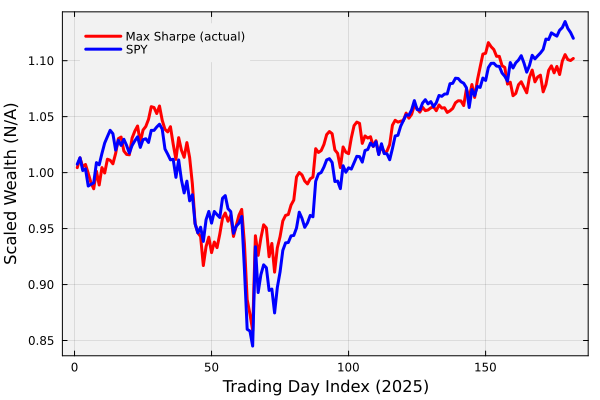

In [45]:
let
    
    total_budget = investment_budget;
    plot((1/total_budget).*portfolio_performance_array[:,end], lw=3, 
        c=:red, label="Max Sharpe (actual)")
    plot!((1/total_budget).*SPY_performance_array, lw=3, 
        c=:blue, label="SPY")
    xlabel!("Trading Day Index (2025)", fontsize=18)
    ylabel!("Scaled Wealth (N/A)", fontsize=18)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

__Hypothesis__: Because of price movement, we expect that the initial (optimal) allocation will change over time even though the number of shares held for each asset $n_{i}$ is held constant.

Let's compute the `drift_array::Array{Float64,2}` array, which holds the fraction of the liquidation value held in any given ticker (column) for each day of the trading period. 

In [47]:
drift_array = let
    w = sharpe_solution.w .|> x -> round(x, digits=4) |> abs # optimal weights
    drift_array = Array{Float64,2}(undef, number_of_days, length(w) + 1)
    for i ∈ 1:number_of_days
        
        total_portfolio_value = portfolio_performance_array[i,end];
        for j ∈ eachindex(my_list_of_tickers)
            drift_array[i,j] = (1/total_portfolio_value).*portfolio_performance_array[i,j]
        end
        drift_array[i,end] = sum(drift_array[i,1:end-1])
    end
    drift_array;
end

182×22 Matrix{Float64}:
 0.240634  0.275964  0.0  0.0  …  0.0  0.0473203  0.0  0.0  0.0  1.0
 0.240197  0.276528  0.0  0.0     0.0  0.0472541  0.0  0.0  0.0  1.0
 0.239349  0.275155  0.0  0.0     0.0  0.0473066  0.0  0.0  0.0  1.0
 0.239299  0.275966  0.0  0.0     0.0  0.0477159  0.0  0.0  0.0  1.0
 0.235397  0.274495  0.0  0.0     0.0  0.0487258  0.0  0.0  0.0  1.0
 0.234906  0.275623  0.0  0.0  …  0.0  0.0483559  0.0  0.0  0.0  1.0
 0.235085  0.276147  0.0  0.0     0.0  0.0482318  0.0  0.0  0.0  1.0
 0.235962  0.278788  0.0  0.0     0.0  0.0477654  0.0  0.0  0.0  1.0
 0.22924   0.281103  0.0  0.0     0.0  0.0483371  0.0  0.0  0.0  1.0
 0.227389  0.279648  0.0  0.0     0.0  0.0479218  0.0  0.0  0.0  1.0
 0.221199  0.280657  0.0  0.0  …  0.0  0.0487513  0.0  0.0  0.0  1.0
 0.21967   0.288687  0.0  0.0     0.0  0.0482345  0.0  0.0  0.0  1.0
 0.219706  0.289284  0.0  0.0     0.0  0.0485794  0.0  0.0  0.0  1.0
 ⋮                             ⋱                            ⋮    
 0.210083  0.

`Unhide` the code block below to see how we visualize the portfolio allocation fractions $\omega_{i}$ for each asset in the portfolio as a function of time.

In [49]:
let
    column_name_array = Array{String,1}();
    for ticker ∈ my_list_of_tickers
        push!(column_name_array, ticker);
    end
    push!(column_name_array, "total")
    df = DataFrame(drift_array, column_name_array)
    

    pretty_table(df, backend = :text, fit_table_in_display_vertically = false, fit_table_in_display_horizontally = false,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 ---------- ---------- --------- --------- ----------- --------- --------- --------- --------- --------- --------- --------- ----------- --------- --------- ---------- --------- ----------- --------- --------- --------- ---------
      AAPL       MSFT      INTC        MU         AMD        GS       BAC       WFC         C         F        GM       JNJ         CHD        PG       UPS       COST       TGT         WMT       MRK       PFE      ADBE     total 
   Float64    Float64   Float64   Float64     Float64   Float64   Float64   Float64   Float64   Float64   Float64   Float64     Float64   Float64   Float64    Float64   Float64     Float64   Float64   Float64   Float64   Float64 
 ---------- ---------- --------- --------- ----------- --------- --------- --------- --------- --------- --------- --------- ----------- --------- --------- ---------- --------- ----------- --------- --------- --------- ---------
  0.240634   0.275964       0.0       0.0   0.0568424       0.0       0.0       

As the prices of the underlying assets change, the portfolio allocation drifts away from its initial optimal composition. Over the 182-day holding period, the relative portfolio weights have shifted significantly. Let's compute the portfolio's alpha and beta on the final day to see how the risk-return characteristics have changed:

In [51]:
let

    # initialize -
    α = model.α
    β = model.β

    # get the last day of data -
    w_last_day = drift_array[end, 1:end-1];

    # compute the portfolio statistics on the last day -
    portfolio_alpha = dot(α, w_last_day);
    portfolio_beta = dot(β, w_last_day);

    # print results -
    println("Portfolio Alpha on Last Day: $(round(portfolio_alpha, digits=4))");
    println("Portfolio Beta on Last Day: $(round(portfolio_beta, digits=4))");
end

Portfolio Alpha on Last Day: 0.1046
Portfolio Beta on Last Day: 1.0085


___

## Summary
As asset prices evolve over time, the allocation of a static portfolio (constant number of shares) drifts from its initial optimal composition. This drift changes the portfolio's systematic risk exposure and idiosyncratic component.

> __Key Takeaways:__
> 
> * __Portfolio drift mechanics:__ When asset prices change but the number of shares remains fixed, the portfolio weights (fractions of total value) shift, causing the portfolio to deviate from its initially optimal allocation.
> * __Risk characteristics change:__ As the portfolio drifts, its alpha and beta values evolve, reflecting changes in both systematic market exposure and idiosyncratic performance relative to the original optimal portfolio.
> * __Rebalancing importance:__ Portfolio drift demonstrates why periodic rebalancing is necessary to maintain desired risk-return characteristics and prevent unintended risk exposure changes over time.

Without periodic rebalancing, a portfolio that initially maximizes the Sharpe ratio will have different risk-return properties at subsequent dates.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

___